# Clear Output

In [1]:
from IPython.display import clear_output

# Installing Transformers and Datasets from HuggingFace

In [2]:
! pip install transformers datasets
clear_output()

# Importing libraries

In [11]:
import torch
from torch.utils.data import Dataset
from transformers import DistilBertTokenizerFast,DistilBertForSequenceClassification, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification
from transformers import Trainer,TrainingArguments, pipeline
import pandas as pd
import numpy as np
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split


In [12]:
df = pd.read_csv('news_data_ROW 1 - 1330.csv')

In [19]:
df2 = df[['title', 'Sentimental Analysis' ]].dropna().rename(columns = {'title': 'text', 'Sentimental Analysis': 'score'})

# Re-scale labelled sentiment to 0,1,2 which represents negative, neutral and positive.

In [18]:
def change(x):
    if x==0:
        return 1
    if x==-1:
        return 0
    if x==1:
        return 2

Manually labelled dataset

In [20]:
df2['score'] = df2.score.apply(change)
df2.head()

,text,score
0,Cloverleaf Networks Acquires Ryver to Enhance ...,1
1,Ingalls Shipbuilding Successfully Completes Ac...,1
2,"STONERIDGE, INC. TO BROADCAST ITS THIRD-QUARTE...",1
3,Volatile Brazil Is Lone Bull Case for Bruised ...,2
4,Civitas Resources (CIVI) Gains But Lags Market...,2


Split to Train-Test set just for manual dataset

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df2.text, df2.score, test_size=0.2, random_state=42)

# Labelled Financial News from Huggingface

In [26]:
from datasets import load_dataset
dataset = load_dataset('financial_phrasebank', 'sentences_50agree')

In [32]:
pdf = pd.DataFrame(dataset['train'])

In [33]:
pdf

,sentence,label
0,"According to Gran , the company has no plans t...",1
1,Technopolis plans to develop in stages an area...,1
2,The international electronic industry company ...,0
3,With the new production plant the company woul...,2
4,According to the company 's updated strategy f...,2
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,Net sales of the Paper segment decreased to EU...,0


Append the manual labelled dataset

In [34]:
df3 = df2[['text','score']].append(pdf.rename(columns = {'sentence':'text', 'label':'score'}))

/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/1819253798.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df3 = df2[['text','score']].append(pdf.rename(columns = {'sentence':'text', 'label':'score'}))


In [35]:
df3

,text,score
0,Cloverleaf Networks Acquires Ryver to Enhance ...,1
1,Ingalls Shipbuilding Successfully Completes Ac...,1
2,"STONERIDGE, INC. TO BROADCAST ITS THIRD-QUARTE...",1
3,Volatile Brazil Is Lone Bull Case for Bruised ...,2
4,Civitas Resources (CIVI) Gains But Lags Market...,2
...,...,...
4841,LONDON MarketWatch -- Share prices ended lower...,0
4842,Rinkuskiai 's beer sales fell by 6.5 per cent ...,1
4843,Operating profit fell to EUR 35.4 mn from EUR ...,0
4844,Net sales of the Paper segment decreased to EU...,0


Split into train-test sets

In [36]:
X_train, X_test, y_train, y_test = train_test_split(df3.text, df3.score, test_size=0.2, random_state=42)

# Sentiment-Analysis 

Name of our model

In [37]:
model_name = 'distilbert-base-uncased'

Loading Tokenizer from pretrained DistilBERT and define number of label and the droupout rate

In [38]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',num_labels=3, dropout=0.5, attention_dropout=0.5)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Encoding the input datatset to vectors

In [39]:
model_name = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',num_labels=3, dropout=0.5, attention_dropout=0.5)
train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True,return_tensors = 'pt')
val_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True,return_tensors = 'pt')

Defining class Dataset which PyTorch requires

In [40]:
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [41]:
train_dataset = SentimentDataset(train_encodings, y_train.to_list())
val_dataset = SentimentDataset(val_encodings, y_test.to_list())

Hyper-parameters

In [46]:
training_args = TrainingArguments(
    output_dir='training',          # output directory
    evaluation_strategy="steps",
    num_train_epochs=10,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs4',            # directory for storing logs
    logging_steps=50,
    load_best_model_at_end=True,
)

using `logging_steps` to initialize `eval_steps` to 50
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


Define a custom computer metrics to get Accuracy and f1_score during the training

In [47]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    #recall = recall_score(y_true=labels, y_pred=pred)
    #precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(labels, pred, average='weighted')

    return {"accuracy": accuracy,"f1_score":f1}

Instantiate the model and start training

In [48]:
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3, dropout=0.5, attention_dropout=0.5)

trainer = Trainer(
    model=model,# the instantiated Transformers model to be trained
    args=training_args, # training arguments, defined above
    train_dataset=train_dataset,# training dataset
    eval_dataset=val_dataset , # evaluation dataset
    compute_metrics=compute_metrics,
)

trainer.train()
trainer.save_model()

loading configuration file config.json from cache at /Users/bytedance/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.5,
  "dim": 768,
  "dropout": 0.5,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.23.1",
  "vocab_size": 30522
}

loading weights file pytorch_model.bin from cache at /Users/bytedance/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd

  0%|          | 0/1550 [00:00<?, ?it/s]

/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 1.0616, 'learning_rate': 5e-06, 'epoch': 0.32}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 1.0090727806091309, 'eval_accuracy': 0.6097165991902834, 'eval_f1_score': 0.4618879267507881, 'eval_runtime': 19.9103, 'eval_samples_per_second': 62.028, 'eval_steps_per_second': 1.005, 'epoch': 0.32}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.9324, 'learning_rate': 1e-05, 'epoch': 0.65}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.9025490283966064, 'eval_accuracy': 0.6097165991902834, 'eval_f1_score': 0.4618879267507881, 'eval_runtime': 19.7808, 'eval_samples_per_second': 62.434, 'eval_steps_per_second': 1.011, 'epoch': 0.65}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.8563, 'learning_rate': 1.5e-05, 'epoch': 0.97}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.8422989845275879, 'eval_accuracy': 0.6178137651821862, 'eval_f1_score': 0.4823997529226821, 'eval_runtime': 18.636, 'eval_samples_per_second': 66.269, 'eval_steps_per_second': 1.073, 'epoch': 0.97}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.8178, 'learning_rate': 2e-05, 'epoch': 1.29}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.775526225566864, 'eval_accuracy': 0.6615384615384615, 'eval_f1_score': 0.5784195464857611, 'eval_runtime': 19.5106, 'eval_samples_per_second': 63.299, 'eval_steps_per_second': 1.025, 'epoch': 1.29}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.7404, 'learning_rate': 2.5e-05, 'epoch': 1.61}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.7193660140037537, 'eval_accuracy': 0.668825910931174, 'eval_f1_score': 0.5955975960067385, 'eval_runtime': 19.8569, 'eval_samples_per_second': 62.195, 'eval_steps_per_second': 1.007, 'epoch': 1.61}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.6543, 'learning_rate': 3e-05, 'epoch': 1.94}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.6287842988967896, 'eval_accuracy': 0.7327935222672065, 'eval_f1_score': 0.6917034048059206, 'eval_runtime': 19.817, 'eval_samples_per_second': 62.32, 'eval_steps_per_second': 1.009, 'epoch': 1.94}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.6174, 'learning_rate': 3.5e-05, 'epoch': 2.26}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.5734500885009766, 'eval_accuracy': 0.7497975708502024, 'eval_f1_score': 0.7179064613806804, 'eval_runtime': 20.051, 'eval_samples_per_second': 61.593, 'eval_steps_per_second': 0.997, 'epoch': 2.26}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.5525, 'learning_rate': 4e-05, 'epoch': 2.58}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.5187347531318665, 'eval_accuracy': 0.7692307692307693, 'eval_f1_score': 0.7551111009267645, 'eval_runtime': 19.1615, 'eval_samples_per_second': 64.452, 'eval_steps_per_second': 1.044, 'epoch': 2.58}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.5431, 'learning_rate': 4.5e-05, 'epoch': 2.9}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.5188854336738586, 'eval_accuracy': 0.7781376518218623, 'eval_f1_score': 0.7801954598013459, 'eval_runtime': 19.7679, 'eval_samples_per_second': 62.475, 'eval_steps_per_second': 1.012, 'epoch': 2.9}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.4989, 'learning_rate': 5e-05, 'epoch': 3.23}


  0%|          | 0/20 [00:00<?, ?it/s]

Saving model checkpoint to training/checkpoint-500
Configuration saved in training/checkpoint-500/config.json


{'eval_loss': 0.5009760856628418, 'eval_accuracy': 0.794331983805668, 'eval_f1_score': 0.7963676282309027, 'eval_runtime': 18.1562, 'eval_samples_per_second': 68.021, 'eval_steps_per_second': 1.102, 'epoch': 3.23}


Model weights saved in training/checkpoint-500/pytorch_model.bin
/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.5204, 'learning_rate': 4.761904761904762e-05, 'epoch': 3.55}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.4413304924964905, 'eval_accuracy': 0.8178137651821862, 'eval_f1_score': 0.8185034175537553, 'eval_runtime': 17.1498, 'eval_samples_per_second': 72.012, 'eval_steps_per_second': 1.166, 'epoch': 3.55}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.4736, 'learning_rate': 4.523809523809524e-05, 'epoch': 3.87}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.4664141535758972, 'eval_accuracy': 0.8, 'eval_f1_score': 0.8050266199301466, 'eval_runtime': 17.2963, 'eval_samples_per_second': 71.403, 'eval_steps_per_second': 1.156, 'epoch': 3.87}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.428, 'learning_rate': 4.2857142857142856e-05, 'epoch': 4.19}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.4425126910209656, 'eval_accuracy': 0.8113360323886639, 'eval_f1_score': 0.8149176568802259, 'eval_runtime': 17.1876, 'eval_samples_per_second': 71.854, 'eval_steps_per_second': 1.164, 'epoch': 4.19}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.409, 'learning_rate': 4.047619047619048e-05, 'epoch': 4.52}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.40625837445259094, 'eval_accuracy': 0.8412955465587044, 'eval_f1_score': 0.8413864470937807, 'eval_runtime': 17.0693, 'eval_samples_per_second': 72.352, 'eval_steps_per_second': 1.172, 'epoch': 4.52}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.4358, 'learning_rate': 3.809523809523809e-05, 'epoch': 4.84}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.44561031460762024, 'eval_accuracy': 0.8113360323886639, 'eval_f1_score': 0.8158938485152638, 'eval_runtime': 17.0924, 'eval_samples_per_second': 72.254, 'eval_steps_per_second': 1.17, 'epoch': 4.84}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.409, 'learning_rate': 3.571428571428572e-05, 'epoch': 5.16}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.4019330143928528, 'eval_accuracy': 0.8437246963562753, 'eval_f1_score': 0.8448590924085855, 'eval_runtime': 17.0746, 'eval_samples_per_second': 72.329, 'eval_steps_per_second': 1.171, 'epoch': 5.16}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.3959, 'learning_rate': 3.3333333333333335e-05, 'epoch': 5.48}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.3796737790107727, 'eval_accuracy': 0.8647773279352227, 'eval_f1_score': 0.8648234148272979, 'eval_runtime': 17.1169, 'eval_samples_per_second': 72.151, 'eval_steps_per_second': 1.168, 'epoch': 5.48}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.348, 'learning_rate': 3.095238095238095e-05, 'epoch': 5.81}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.4504992663860321, 'eval_accuracy': 0.8161943319838056, 'eval_f1_score': 0.8202364407597721, 'eval_runtime': 17.1451, 'eval_samples_per_second': 72.032, 'eval_steps_per_second': 1.167, 'epoch': 5.81}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.3498, 'learning_rate': 2.857142857142857e-05, 'epoch': 6.13}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.4367295205593109, 'eval_accuracy': 0.8299595141700404, 'eval_f1_score': 0.8333816308731581, 'eval_runtime': 17.7073, 'eval_samples_per_second': 69.745, 'eval_steps_per_second': 1.129, 'epoch': 6.13}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.3314, 'learning_rate': 2.6190476190476192e-05, 'epoch': 6.45}


  0%|          | 0/20 [00:00<?, ?it/s]

Saving model checkpoint to training/checkpoint-1000
Configuration saved in training/checkpoint-1000/config.json


{'eval_loss': 0.47549647092819214, 'eval_accuracy': 0.8072874493927126, 'eval_f1_score': 0.8118977019047231, 'eval_runtime': 17.6131, 'eval_samples_per_second': 70.118, 'eval_steps_per_second': 1.136, 'epoch': 6.45}


Model weights saved in training/checkpoint-1000/pytorch_model.bin
/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.3329, 'learning_rate': 2.380952380952381e-05, 'epoch': 6.77}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.44489964842796326, 'eval_accuracy': 0.8234817813765182, 'eval_f1_score': 0.8274732363533813, 'eval_runtime': 17.8167, 'eval_samples_per_second': 69.317, 'eval_steps_per_second': 1.123, 'epoch': 6.77}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.3405, 'learning_rate': 2.1428571428571428e-05, 'epoch': 7.1}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.4019692838191986, 'eval_accuracy': 0.8396761133603239, 'eval_f1_score': 0.8420816352775391, 'eval_runtime': 17.7236, 'eval_samples_per_second': 69.681, 'eval_steps_per_second': 1.128, 'epoch': 7.1}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.3107, 'learning_rate': 1.9047619047619046e-05, 'epoch': 7.42}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.3741989731788635, 'eval_accuracy': 0.8566801619433199, 'eval_f1_score': 0.8576204369475364, 'eval_runtime': 17.7937, 'eval_samples_per_second': 69.406, 'eval_steps_per_second': 1.124, 'epoch': 7.42}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.3093, 'learning_rate': 1.6666666666666667e-05, 'epoch': 7.74}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.4003281593322754, 'eval_accuracy': 0.8429149797570851, 'eval_f1_score': 0.8454625869637503, 'eval_runtime': 17.6444, 'eval_samples_per_second': 69.994, 'eval_steps_per_second': 1.134, 'epoch': 7.74}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.3159, 'learning_rate': 1.4285714285714285e-05, 'epoch': 8.06}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.40188390016555786, 'eval_accuracy': 0.8453441295546559, 'eval_f1_score': 0.8473978401605198, 'eval_runtime': 17.3936, 'eval_samples_per_second': 71.003, 'eval_steps_per_second': 1.15, 'epoch': 8.06}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.259, 'learning_rate': 1.1904761904761905e-05, 'epoch': 8.39}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.40793827176094055, 'eval_accuracy': 0.8502024291497976, 'eval_f1_score': 0.8517307117261931, 'eval_runtime': 17.3394, 'eval_samples_per_second': 71.225, 'eval_steps_per_second': 1.153, 'epoch': 8.39}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.2853, 'learning_rate': 9.523809523809523e-06, 'epoch': 8.71}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.41443493962287903, 'eval_accuracy': 0.8461538461538461, 'eval_f1_score': 0.8481301828175124, 'eval_runtime': 18.823, 'eval_samples_per_second': 65.611, 'eval_steps_per_second': 1.063, 'epoch': 8.71}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.2514, 'learning_rate': 7.142857142857143e-06, 'epoch': 9.03}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.44671985507011414, 'eval_accuracy': 0.8340080971659919, 'eval_f1_score': 0.8372416040217894, 'eval_runtime': 18.6734, 'eval_samples_per_second': 66.137, 'eval_steps_per_second': 1.071, 'epoch': 9.03}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.2457, 'learning_rate': 4.7619047619047615e-06, 'epoch': 9.35}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.43733078241348267, 'eval_accuracy': 0.8364372469635628, 'eval_f1_score': 0.8393011463697656, 'eval_runtime': 17.5707, 'eval_samples_per_second': 70.287, 'eval_steps_per_second': 1.138, 'epoch': 9.35}


/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.2636, 'learning_rate': 2.3809523809523808e-06, 'epoch': 9.68}


  0%|          | 0/20 [00:00<?, ?it/s]

Saving model checkpoint to training/checkpoint-1500
Configuration saved in training/checkpoint-1500/config.json


{'eval_loss': 0.43212178349494934, 'eval_accuracy': 0.8380566801619433, 'eval_f1_score': 0.840893097318563, 'eval_runtime': 17.1964, 'eval_samples_per_second': 71.818, 'eval_steps_per_second': 1.163, 'epoch': 9.68}


Model weights saved in training/checkpoint-1500/pytorch_model.bin
/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64


{'loss': 0.2737, 'learning_rate': 0.0, 'epoch': 10.0}


  0%|          | 0/20 [00:00<?, ?it/s]



Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from training/checkpoint-1500 (score: 0.43212178349494934).
Saving model checkpoint to training
Configuration saved in training/config.json


{'eval_loss': 0.4336535632610321, 'eval_accuracy': 0.8380566801619433, 'eval_f1_score': 0.8408586216932001, 'eval_runtime': 17.7335, 'eval_samples_per_second': 69.642, 'eval_steps_per_second': 1.128, 'epoch': 10.0}
{'train_runtime': 5585.0892, 'train_samples_per_second': 8.845, 'train_steps_per_second': 0.278, 'train_loss': 0.46979688705936556, 'epoch': 10.0}


Model weights saved in training/pytorch_model.bin


#Evaluation of the model

In [49]:
import numpy as np
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1235
  Batch size = 64
/var/folders/b1/0fd1b6hs7lz0fm_mh346lybm0000gn/T/ipykernel_90568/283397799.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}


  0%|          | 0/20 [00:00<?, ?it/s]

{'eval_loss': 0.43212178349494934,
 'eval_accuracy': 0.8380566801619433,
 'eval_f1_score': 0.840893097318563,
 'eval_runtime': 17.8042,
 'eval_samples_per_second': 69.366,
 'eval_steps_per_second': 1.123,
 'epoch': 10.0}

# Visualiaztion 

In [50]:
import json

with open('training/checkpoint-1000/trainer_state.json', 'r') as f:
    train_data = json.load(f)['log_history']

In [51]:
training_loss = {}
validation_loss = {}
validation_acc = {}
for idx, data in enumerate(train_data):
    if idx%2==0:
        training_loss[data['step']] = data['loss']
    else:
        validation_loss[data['step']] = data['eval_loss']
        validation_acc[data['step']] = data['eval_accuracy']

Text(0.5, 0, 'Steps')

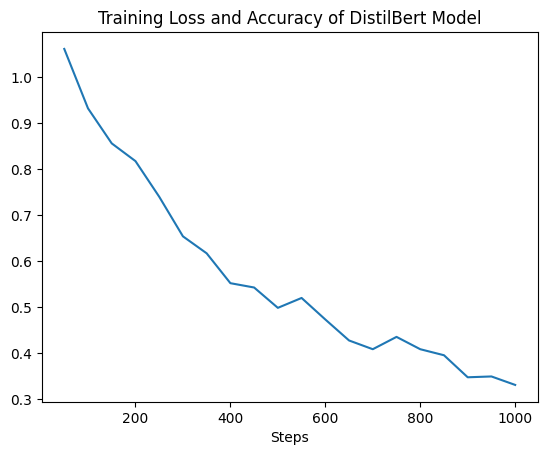

In [52]:
import matplotlib.pyplot as plt

plt.plot(list(training_loss.keys()), list(training_loss.values()))
plt.title("Training Loss and Accuracy of DistilBert Model")
plt.xlabel("Steps")

Text(0.5, 0, 'Steps')

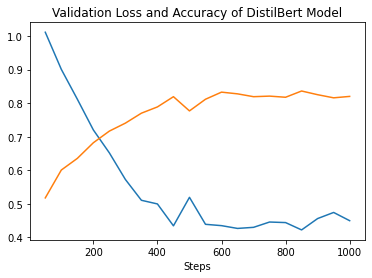

In [ ]:
import matplotlib.pyplot as plt

plt.plot(list(validation_loss.keys()), list(validation_loss.values()))
plt.plot(list(validation_acc.keys()), list(validation_acc.values()))
plt.title("Validation Loss and Accuracy of DistilBert Model")
plt.xlabel('Steps')

# Testing the model

In [56]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased',num_labels=3)
model= DistilBertForSequenceClassification.from_pretrained('training')
clear_output()

Creating a pipeline for the sentimen analysis 

In [57]:
sentiment = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

Enter desired sentence to test


*   LABEL_0: NEGATIVE
*   LABEL_1: NEUTRAL
*   LABEL_2: POSITIVE



In [58]:
print(sentiment('Samsung\'s stock went down by 20%')[0]['label'])
print(sentiment('Samsung\'s is a company')[0]['label'])
print(sentiment('Samsung\'s stock went up by 20%')[0]['label'])

LABEL_0
LABEL_1
LABEL_2


In [5]:
# default_text = "Samsung has made 200% profit, earning $50M this year."


2022-11-02 02:27:18.237 
  command:

    streamlit run /Users/bytedance/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py [ARGUMENTS]


In [8]:
!streamlit run /Users/bytedance/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py


  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.81.28.9:8501

2022-11-02 02:28:42.718 Uncaught app exception
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.10/site-packages/streamlit/runtime/scriptrunner/script_runner.py", line 562, in _run_script
    exec(code, module.__dict__)
  File "/Users/bytedance/Library/Python/3.9/lib/python/site-packages/ipykernel_launcher.py", line 15, in <module>
    from ipykernel import kernelapp as app
  File "/Users/bytedance/Library/Python/3.9/lib/python/site-packages/ipykernel/__init__.py", line 5, in <module>
    from .connect import *  # noqa
  File "/Users/bytedance/Library/Python/3.9/lib/python/site-packages/ipykernel/connect.py", line 11, in <module>
    import jupyter_client
  File "/Users/bytedance/Library/Python/3.9/lib/python/site-packages/jupyter_client/__init__.py", line 8, in <module>
    from .asynchronous import AsyncKernelClient  # noqa
  File "/Us